In [1]:
import anndata
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import statsmodels.api as sm
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import scanpy as sc
from matplotlib_venn import venn2
import scrublet as scr
import pandas as pd
from pybiomart import Server
from upsetty import Upset
from tqdm import tqdm
from scipy import sparse
import multiprocessing

In [2]:
%matplotlib inline

In [3]:
outdir = "/mnt/data1/10XvParse/Analysis_2/"
fasta_folder = "FASTA/Processed/"
sample_folder = "FASTA/Sampled/"
sra_folder = "SRA/"
tmp_folder = "tmp/"

In [4]:
names = ['10x', 'polyT', 'randO', 'parse']

In [5]:
min_counts = 187061165

# Downsample

In [8]:
def subSample(name):
    path = outdir + fasta_folder + name
    out = outdir + sample_folder + name
    !seqtk sample -s 42 {path+"_1.fastq.gz"} {min_counts} | pigz -p 8 > {out+"_1.fastq.gz"}
    print("Starting",name,"second read subsampling")
    !seqtk sample -s 42 {path+"_2.fastq.gz"} {min_counts} | pigz -p 8 > {out+"_2.fastq.gz"}
    print("Finished",name)

with multiprocessing.Pool(processes=1) as pool:
    print(pool.map(subSample,names))
    print("done")

Starting randO second read subsampling
Finished randO
Starting parse second read subsampling
Finished parse
[None, None]
done


In [9]:
def align(iter):
    name = iter[0]
    tech = iter[1]
    path = outdir + sample_folder + name
    out = outdir + "sample_" + name + "_out"
    !kb count --overwrite --h5ad -r parse_extraction/replace.txt \
        -i index.idx -g t2g.txt -x {tech} -o {out} \
        {path+"_1.fastq.gz"} {path+"_2.fastq.gz"}
    print("Finished",name)

with multiprocessing.Pool(processes=2) as pool:
    iter = zip(names,
               ['10XV3', "SPLIT-SEQ", "SPLIT-SEQ", "SPLIT-SEQ"])
    print(pool.map(align,iter))
    print("done")

[2025-07-30 16:12:09,364]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_2/sample_10x_out from
[2025-07-30 16:12:09,364]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Sampled/10x_1.fastq.gz
[2025-07-30 16:12:09,364]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Sampled/10x_2.fastq.gz
[2025-07-30 16:12:09,365]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_2/sample_polyT_out from
[2025-07-30 16:12:09,365]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Sampled/polyT_1.fastq.gz
[2025-07-30 16:12:09,365]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Sampled/polyT_2.fastq.gz
[2025-07-30 16:25:47,382]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_2/sample_10x_out/output.bus to /mnt/data1/10XvParse/Analysis_2/sample_10x_out/tmp/output.s.bus
[2025-07-30 16:26:12,020]    INFO [count] On-list not provided
[2025-07-30 16:26:12,02

In [6]:
datasets = []
for name in names:
    file = outdir + "sample_" + name + "_out/counts_unfiltered/adata.h5ad"
    data = anndata.read_h5ad(file)
    datasets.append(data)

In [7]:
# Filter data to ensure no zero counts/genes/cells
for data, name, title in zip(datasets,
                            ['10x', 'polyT', 'randO', 'parse'],
                            ["10x Genomics", "Parse 3\'", "Parse Random Oligo", "Parse"]):
    
    data.var["transcript_ids"] = data.var.index.tolist()

    gene_names = []
    dir = outdir + "sample_" + name + "_out/counts_unfiltered/"

    with open(dir + 'cells_x_genes.genes.names.txt', 'r') as file:
        for line in file:
            gene_names.append(line.strip())

    data.var_names = gene_names

    data.uns['name'] = name
    data.uns['title'] = title
    sc.pp.filter_cells(data, min_genes=1)
    sc.pp.filter_genes(data, min_cells=1)

In [8]:
aligned_counts = [data.X.sum() / min_counts for data in datasets]
unaligned_counts = [(min_counts - data.X.sum()) / min_counts for data in datasets]

# Population Upsampling Estimation

In [6]:
# Find the projected number of unique transcripts to be found using each method if sampling were to continue
# Using PreSeq (Daley and Smith 2013) based off of the recommendation from this paper: https://www.biorxiv.org/content/10.1101/2024.10.09.615408v1.full.pdf

for data in datasets:
    filename = f"counts/{data.uns['name']}_counts.txt"
    fileout = f"counts/{data.uns['name']}_yield.txt"
    with open(filename, "w") as f:
        counts = data.X.sum(axis=0).A1
        for count in counts:
            f.write(f"{int(count)}\n")
    !preseq lc_extrap -o {fileout} -V {filename}
    with open(fileout, "r") as f:
        rows = []
        first_line = f.readline()
        for line in f:
            rows.append(list(map(float,line.split())))
    data.uns['pred_upsample'] = np.array(rows)

NameError: name 'datasets' is not defined

In [ ]:
plt.figure(figsize=(16, 4))
for data in datasets:
    pred = data.uns['pred_upsample']
    plt.plot(pred[:, 0], pred[:, 1], label=data.uns['title'])
    plt.fill_between(pred[:, 0], pred[:,2], pred[:,3], alpha=0.5)

plt.legend(loc='upper left')
plt.xlim(0,5e8)
plt.ylim(0, 4e4)
plt.xlabel('Total Number of Counts')
plt.ylabel('Projected Number of Unique Transcripts')
plt.show()

# Doublet Detection Comparison

In [13]:
scrubs = []
for data in datasets:
    scrub = scr.Scrublet(data.X, random_state = 42)
    data.obs['doublet_score'], data.obs['predicted_doublet'] = scrub.scrub_doublets()
    scrubs.append(scrub)

Preprocessing...


KeyboardInterrupt: 

In [ ]:
for data in datasets:
    #data.write('final_'+data.uns['name'] + '.h5ad', compression="gzip")

In [ ]:
percent_doublets = []
doublet_thresh = 0.07

for data in datasets:
    percent_doublets.append((data.obs['doublet_score'] > doublet_thresh).sum() / data.shape[0] * 100)

plt.bar([data.uns['title'] for data in datasets], percent_doublets, color='skyblue')
plt.ylabel('Percentage of Predicted Doublets')
plt.title('Predicted Doublet Percentage by Method')

plt.show()

In [ ]:
for scrub in scrubs:
    scrub.plot_histogram()

# Quality Control Comparison

In [9]:
# Scatter plot of genes detected vs. UMI counts
def scatter_reads(ax, data):
    x = np.asarray(data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(data.X>0, axis=1))[:,0]

    ax.scatter(x, y, color="green", alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title'] + " Reads")

# Knee plot with threshold axes
def knee_plot(ax, data, cutoff = 20):
    knee = np.sort((np.array(data.X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]

    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")
    ax.set_title(data.uns['title'] + " Knee Plot")

    print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold for {data.uns['title']}")
    sc.pp.filter_cells(data, min_counts=knee[num_cells])

# Scatter plot for mitochondrial percentage
def mito_scatter(ax, data):
    sc.pl.scatter(data, x='n_counts', y='percent_mito', ax=ax, show=False)
    ax.set_title(data.uns['title'])
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")

# Generates violin plots of selected metadata
def violin_plots(ax_col, data, groups):
    for i, group in enumerate(groups):
        sc.pl.violin(data, group, ax=ax_col[i], stripplot=False, show=False)
        ax_col[i].set_xticks([])

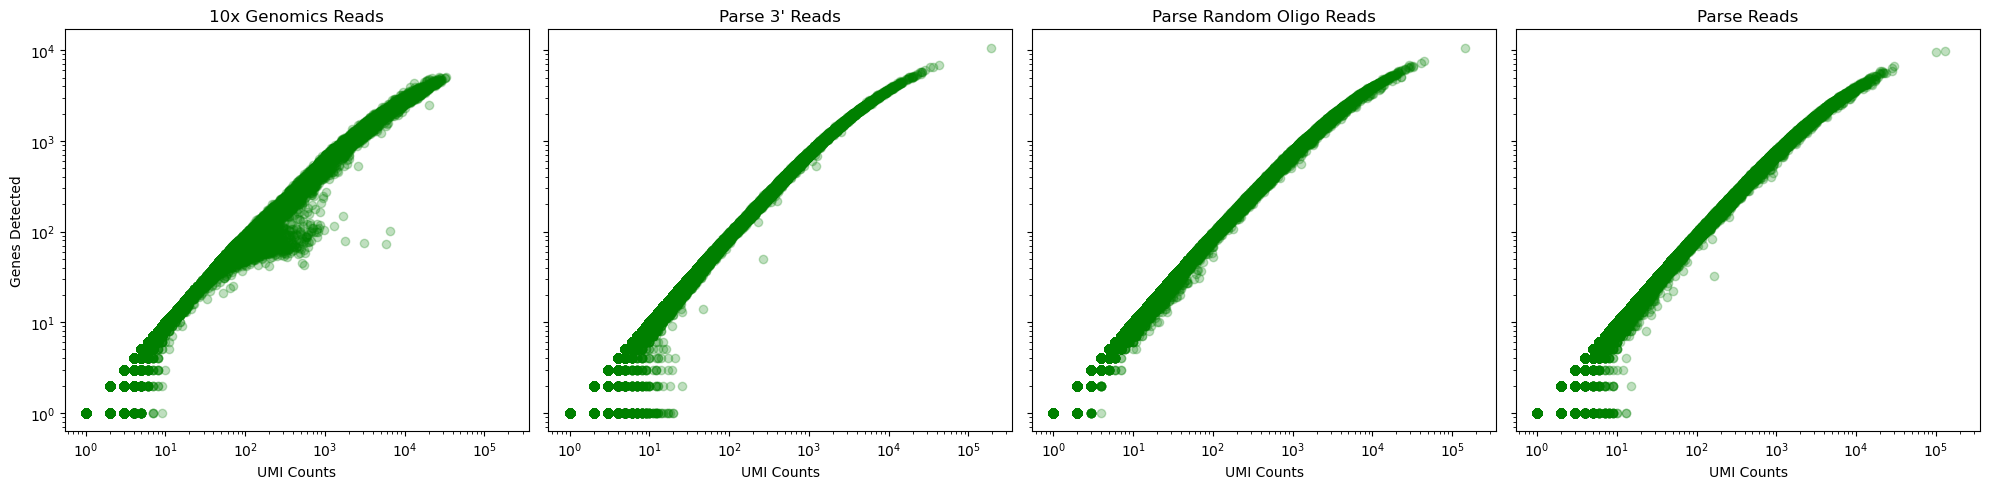

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True,sharex=True)

for i, data in enumerate(datasets):
    scatter_reads(ax[i], data)

ax[0].set_ylabel("Genes Detected")

plt.tight_layout()
plt.show()

13,257 cells passed the 298 UMI threshold for 10x Genomics
13,256 cells passed the 302 UMI threshold for Parse 3'
13,253 cells passed the 271 UMI threshold for Parse Random Oligo
13,262 cells passed the 482 UMI threshold for Parse


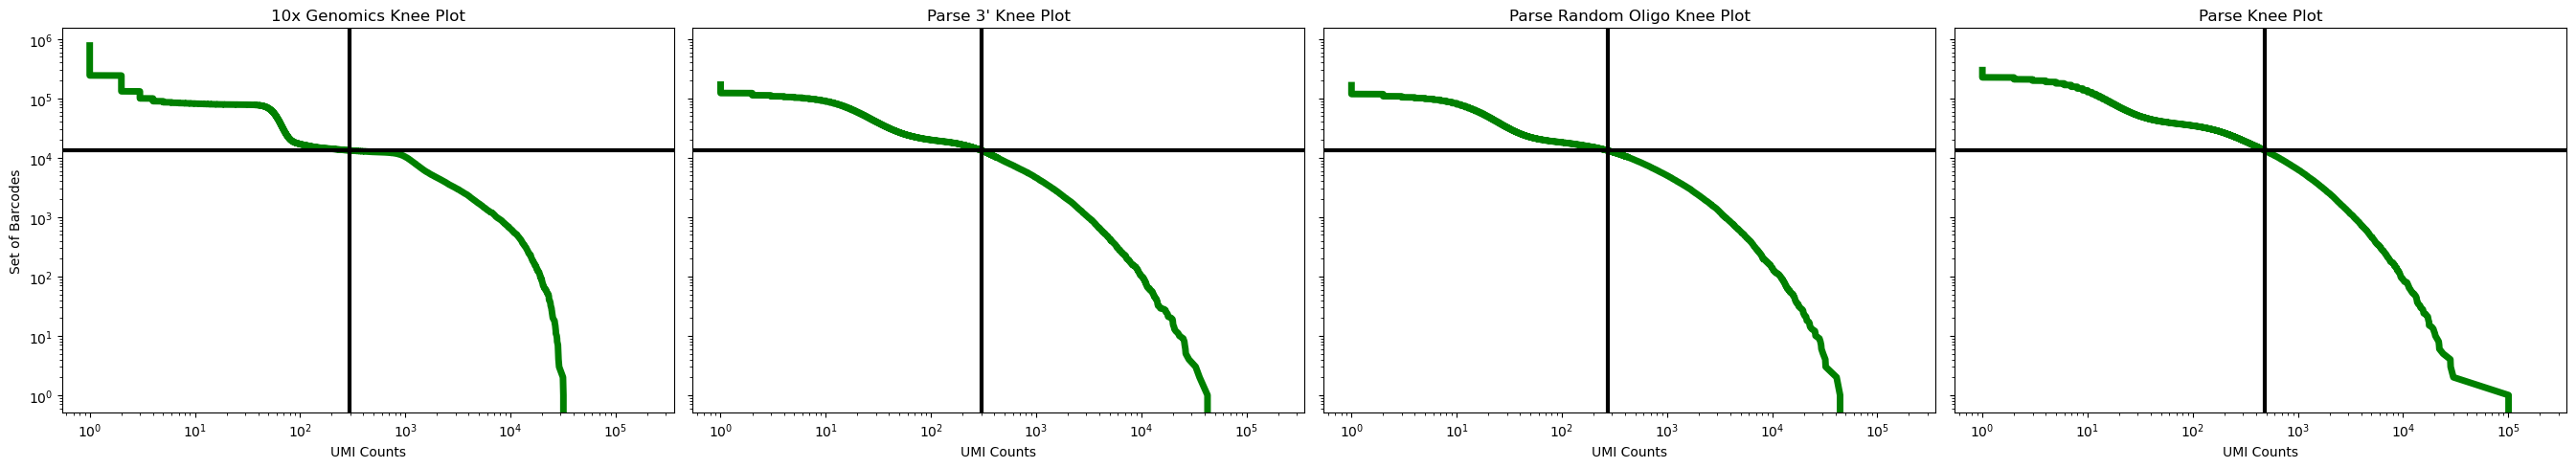

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(27,5), sharey=True,sharex=True)

cutoffs = [298, 302, 271, 482]

for i, (data, cutoff) in enumerate(zip(datasets, cutoffs)):
    knee_plot(ax[i], data, cutoff=cutoff)

ax[0].set_ylabel("Set of Barcodes")

plt.tight_layout()
plt.show()

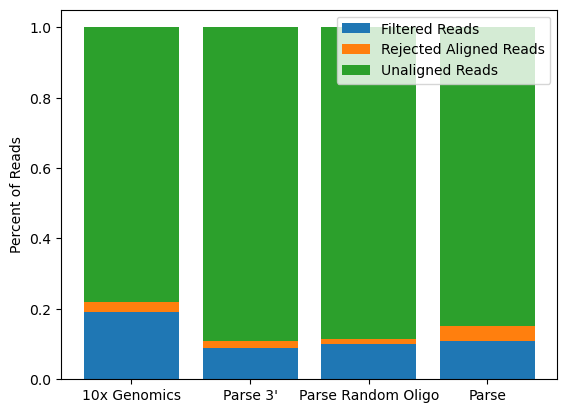

In [12]:
labels = [data.uns['title'] for data in datasets]
rejected_counts = aligned_counts - np.array([data.X.sum() / min_counts for data in datasets])
kept_counts = [data.X.sum() / min_counts for data in datasets]

plt.bar(labels, kept_counts, label = "Filtered Reads")
plt.bar(labels, rejected_counts, bottom=kept_counts, label = "Rejected Aligned Reads")
plt.bar(labels, unaligned_counts, bottom=rejected_counts+kept_counts, label = "Unaligned Reads")
plt.ylabel('Percent of Reads')
plt.legend()

In [13]:
# Query Ensembl for lncRNA genes
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['mmusculus_gene_ensembl']

result = dataset.query(attributes=[
    'ensembl_gene_id_version', 'transcript_biotype'
], filters={'transcript_biotype': ['lncRNA']})

In [14]:
def add_cell_metrics(data):
    lncRNA_genes = set(data.var["transcript_ids"].tolist()).intersection(set(result['Gene stable ID version'].tolist()))
    
    # Identify lncRNA genes
    data.var["is_lnc"] = np.full(len(data.var_names), False)
    data.var.loc[data.var["transcript_ids"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    data.var["is_mito"] = data.var_names.str.startswith("Mt")
    # ribosomal genes
    data.var["is_ribo"] = data.var_names.str.startswith(("Rps", "Rpl"))

    mito_counts = data[:, data.var['is_mito']].X.sum(axis=1)
    ribo_counts = data[:, data.var['is_ribo']].X.sum(axis=1)
    nc_counts = data[:, data.var['is_lnc']].X.sum(axis=1)

    # Calculate total counts per cell
    total_counts = data.X.sum(axis=1)

    # Calculate percent mitochondrial and ribosomal gene expression per cell
    data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
    data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
    data.obs['percent_lnc'] = np.array(nc_counts / total_counts * 100).flatten()

In [15]:
for data in datasets:
    add_cell_metrics(data)

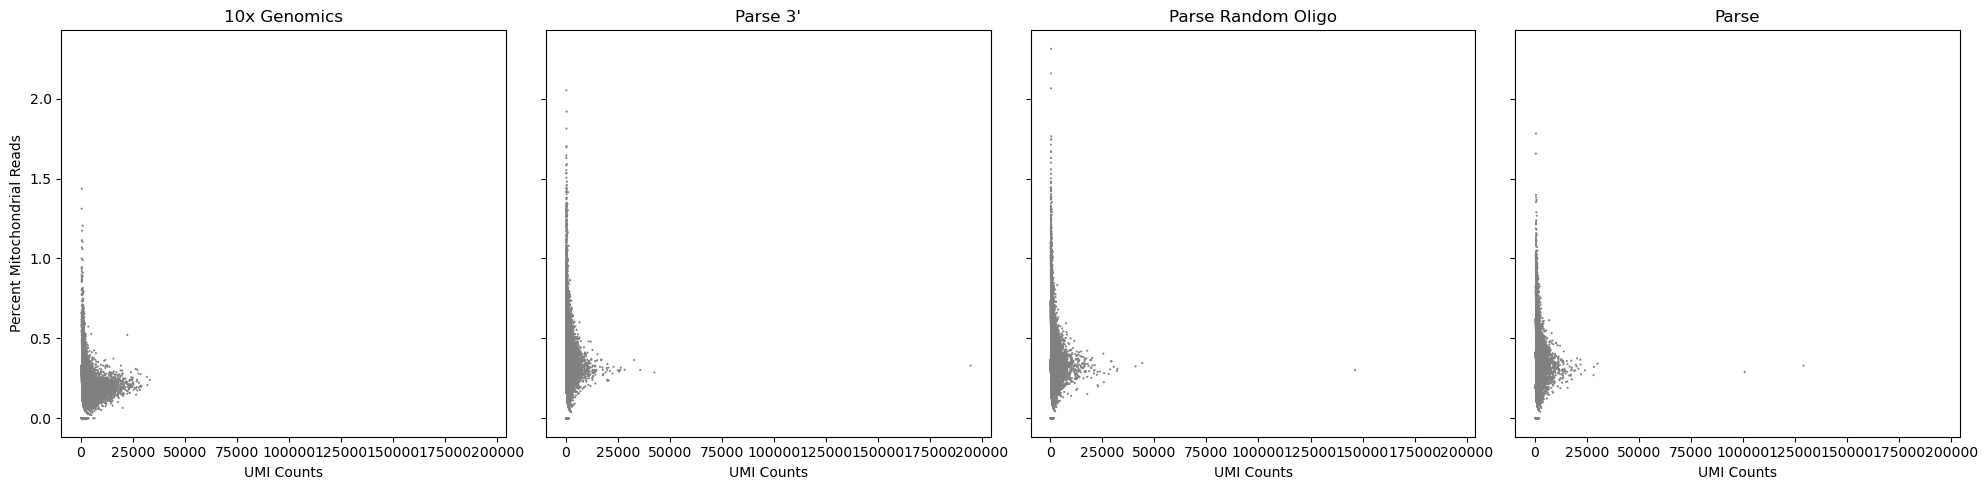

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True,sharex=True)
for i, data in enumerate(datasets):
    mito_scatter(ax[i], data)

ax[0].set_ylabel("Percent Mitochondrial Reads")

plt.tight_layout()
plt.show()

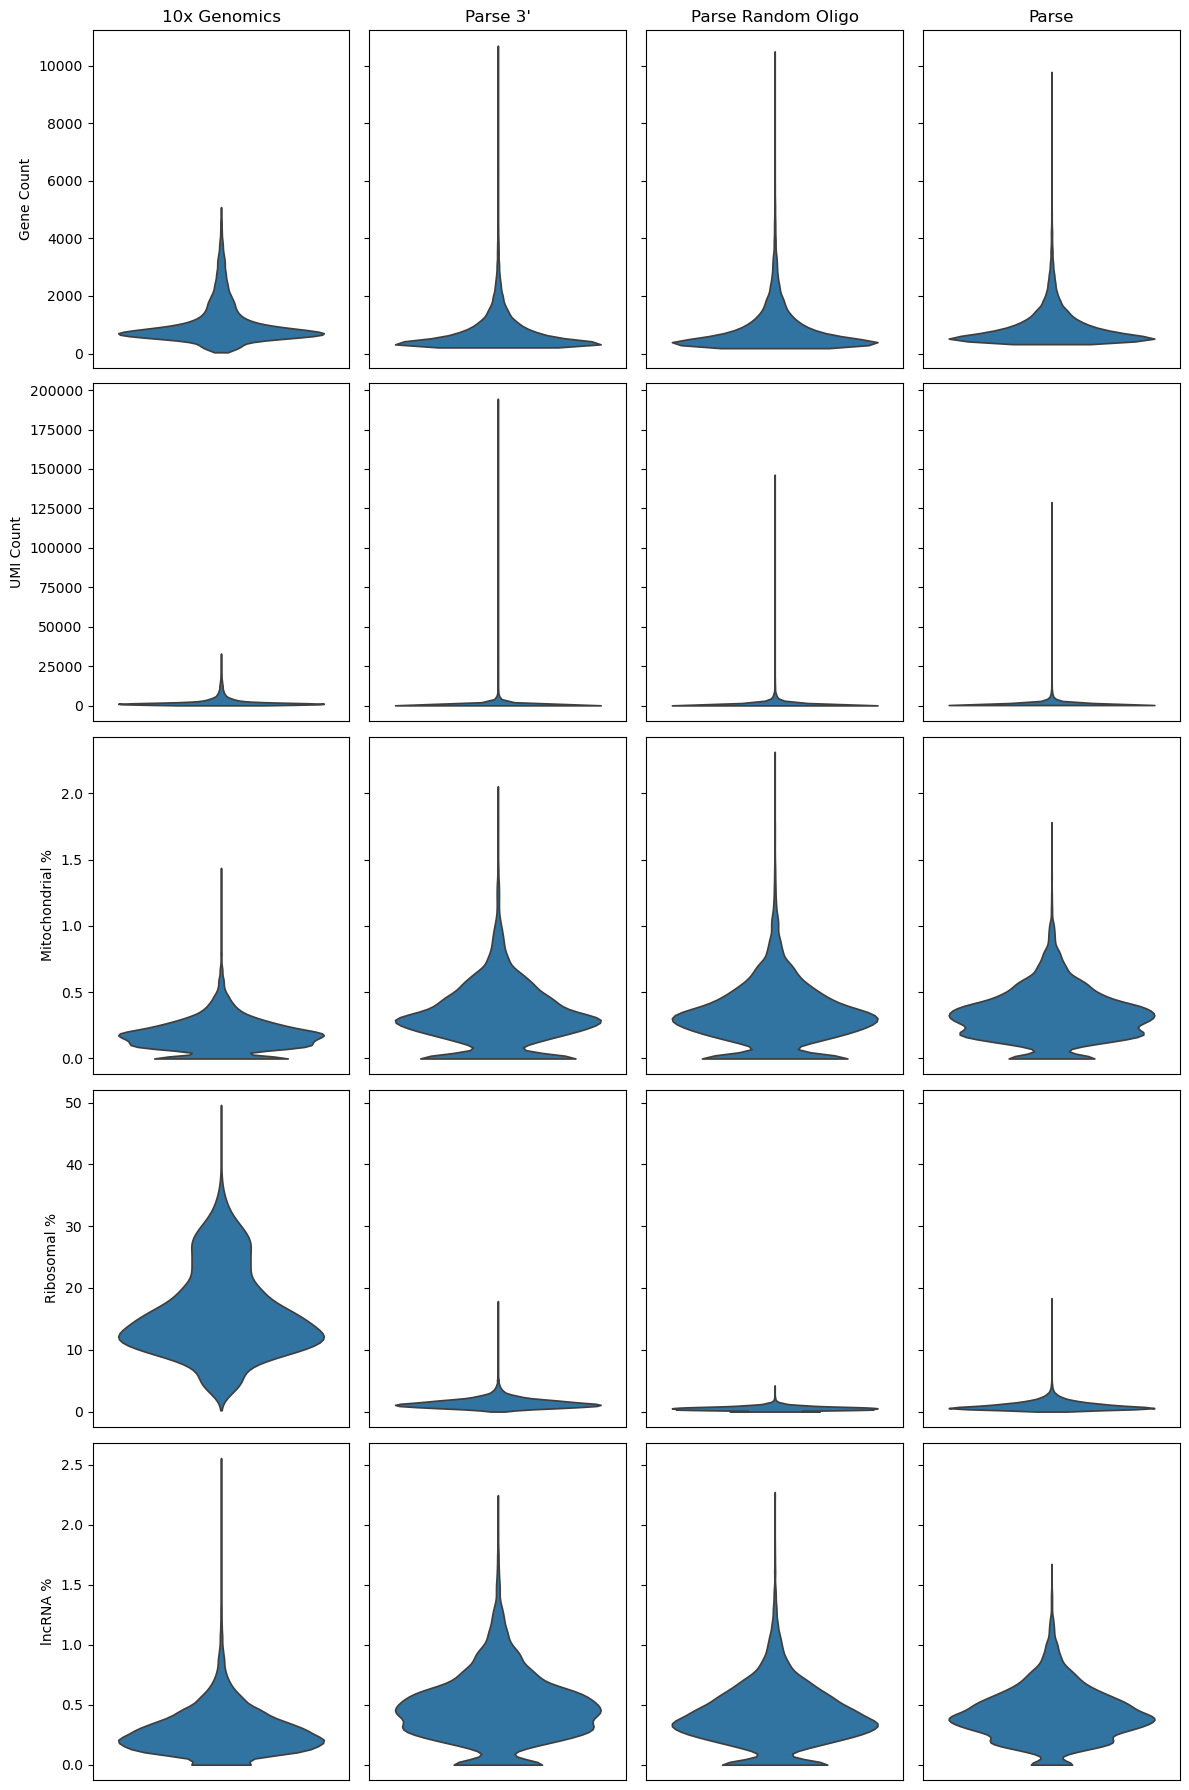

In [17]:
groups = ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc']
group_names = ['Gene Count', 'UMI Count', 'Mitochondrial %', 'Ribosomal %', 'lncRNA %']

fig, ax = plt.subplots(len(groups), 4, figsize=(12,18), sharey='row')
for i, data in enumerate(datasets):
    violin_plots(ax[:, i], data, groups)

for i, group in enumerate(group_names):
    ax[i,0].set_ylabel(group)

for i, data in enumerate(datasets):
    ax[0,i].set_title(data.uns['title'])

plt.tight_layout()
plt.show()

# Read/Transcript Comparisons

In [18]:
# Add percent of counts for each transcript to metadata
for data in datasets: 
    data.var['percent_counts'] = data.X.sum(axis=0).A1 / data.X.sum() * 100

In [19]:
# Displays violin plots of the distributions of the top 10 expressed gene/transcripts
# (by number of cells expressed in) by cell
def top_gene_cell_expression(ax, data, transcript = True):
    genes = data.var
    top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

    if transcript: 
        read_type = "Transcripts"
    else:
        read_type = "Genes"

    gene_dist = []
    for gene in top_genes:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(top_genes) + 1), top_genes)
    ax.set_ylabel("")

    ax.set_title(data.uns['title'] + " Top 10 " + read_type+ " by Cell Expression")

def top_gene_counts(ax, data, transcript = True):
    genes = data.var
    top_genes = genes.sort_values(by='percent_counts',ascending=False).head(10).index

    if transcript: 
        read_type = "Transcripts"
    else:
        read_type = "Genes"

    gene_dist = []
    for gene in top_genes:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(top_genes) + 1), top_genes)
    ax.set_ylabel("")
    ax.set_title(data.uns['title'] + " Top 10 " + read_type + " by Total Counts")

# compares the gene count percentatages between two methods
def compare_genes(data_x, data_y):
    x_name = data_x.uns['name']
    y_name = data_y.uns['name']

    shared_genes = list(set(data_y.var_names).intersection(set(data_x.var_names)))
    shared_data = data_x.var.loc[shared_genes, 'percent_counts'].copy().to_frame()
    shared_data.rename(columns={'percent_counts': x_name + '_percent_counts'}, inplace=True)
    shared_data[y_name + '_percent_counts'] = data_y.var.loc[shared_genes, 'percent_counts'].values
    shared_data.sort_values(by=x_name + '_percent_counts', inplace=True)

    #fit linear regression model
    model = sm.OLS(shared_data[y_name + '_percent_counts'], shared_data[x_name + '_percent_counts']).fit() 
    np.set_printoptions(suppress=True) # suppress scientific notation
    shared_data['cooks_distance'] = model.get_influence().cooks_distance[0] + 1e-10  # add small value to avoid log(0) issues

    return shared_data

# From the output of compare_genes, generates a scatter plot of the gene counts percentages 
# with each method on an axis
def scatter_genes(ax, shared_data, data_x, data_y,  xlim = None, ylim = None, norm = "log", transcript = True):
    x_name = data_x.uns['name']
    y_name = data_y.uns['name']

    if transcript: 
        read_type = "Transcripts"
    else:
        read_type = "Genes"

    #Calculate correlation
    pearson_r = pearsonr(shared_data[x_name + '_percent_counts'], shared_data[y_name + '_percent_counts']).correlation
    spearman_r = spearmanr(shared_data[x_name + '_percent_counts'], shared_data[y_name + '_percent_counts']).correlation
    
    x_mean = shared_data[x_name + '_percent_counts'].mean()
    y_mean = shared_data[y_name + '_percent_counts'].mean()
    x_std = shared_data[x_name + '_percent_counts'].std()
    y_std = shared_data[y_name + '_percent_counts'].std()
    CCC_r = 2 * pearson_r * x_std * y_std / (x_std**2 + y_std**2 + (x_mean - y_mean)**2)

    ax.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=1.5)  # y=x line

    plot = ax.scatter(shared_data[x_name + '_percent_counts'], 
                shared_data[y_name + '_percent_counts'], 
                norm = norm, 
                alpha=0.5, 
                s=50, 
                c=shared_data['cooks_distance'], 
                cmap='viridis')
    
    ax.set_xlabel(data_x.uns['title'] + " " + read_type + ' Percent Count')
    ax.set_ylabel(data_y.uns['title'] + " " + read_type + ' Percent Count')
    if xlim:
        ax.set_xlim(0, xlim)
    if ylim:
        ax.set_ylim(0, ylim)

    textstr = '\n'.join((
    r'$\mathrm{r}=%.2f$' % (pearson_r, ),
    r'$\rho=%.2f$' % (spearman_r, ),
    r'$\rho_C=%.2f$' % (CCC_r, ),))
    ax.text(0.05, 0.85, textstr, transform = ax.transAxes, fontsize = 12)

    return plot

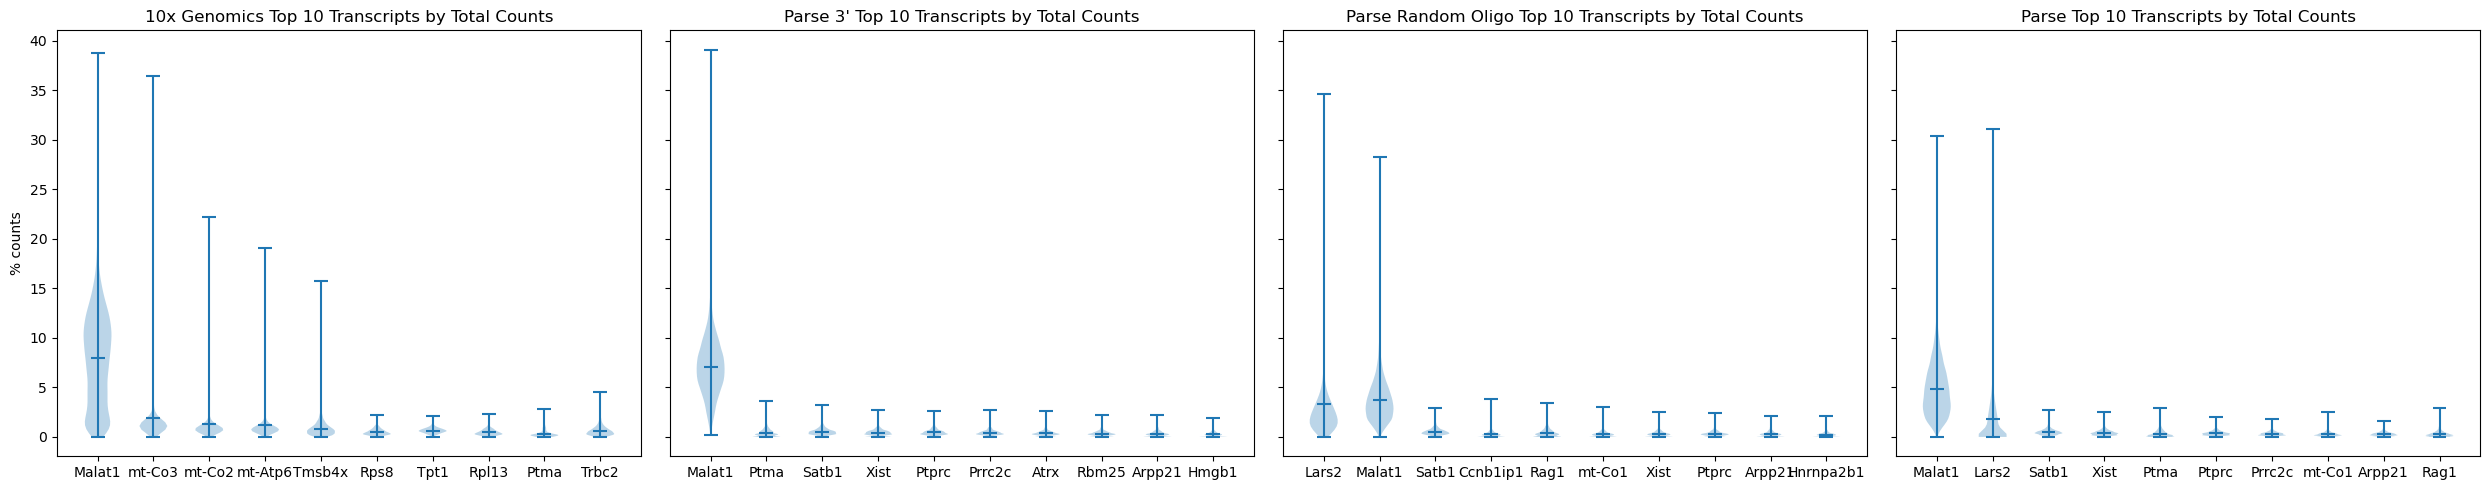

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)

for i, data in enumerate(datasets):
    top_gene_counts(ax[i], data)

ax[0].set_ylabel("% counts")

plt.tight_layout()
plt.show()

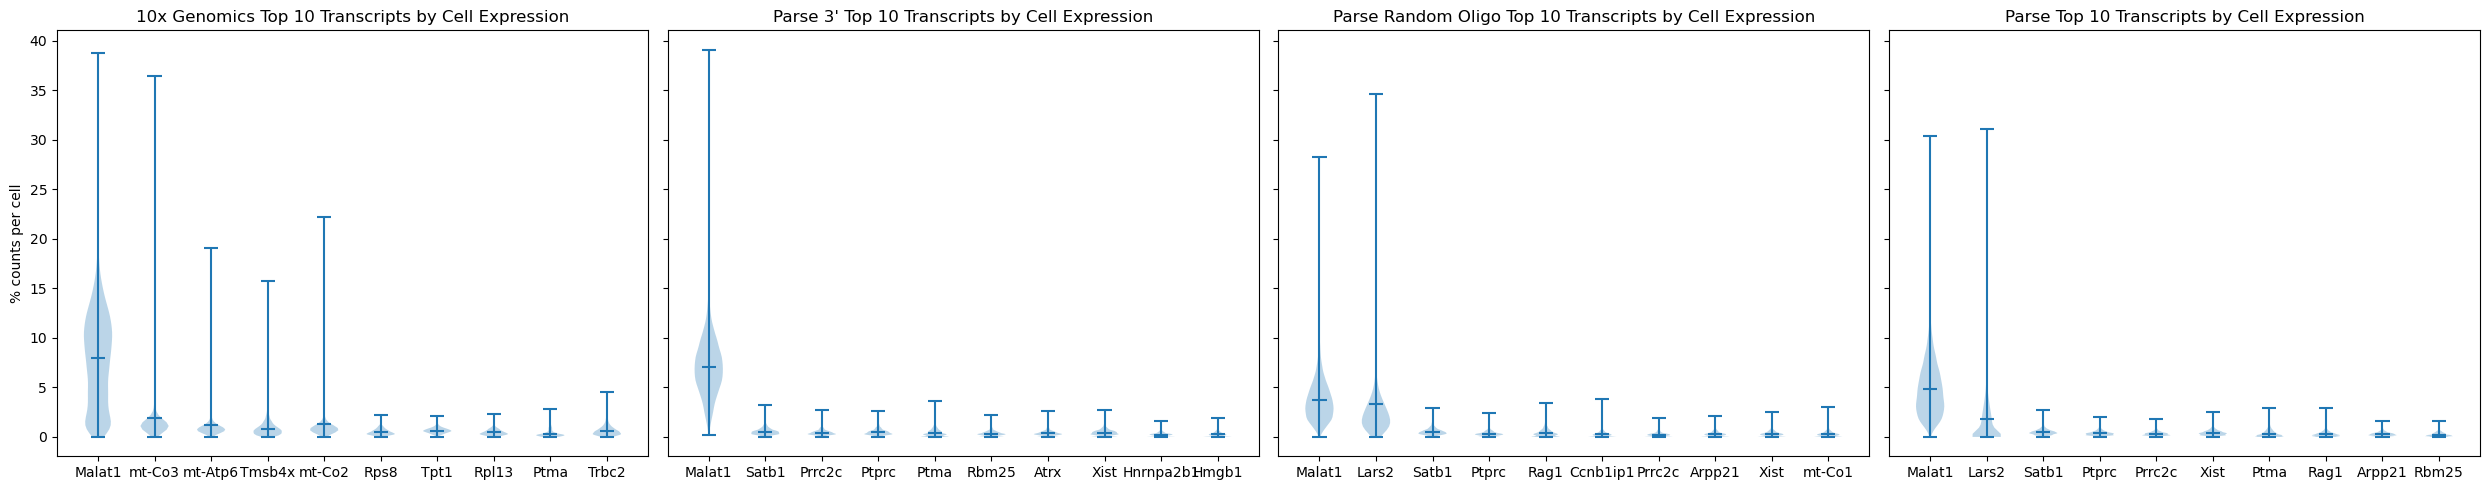

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)
for i, data in enumerate(datasets):
    top_gene_cell_expression(ax[i], data)

ax[0].set_ylabel("% counts per cell")

plt.tight_layout()
plt.show()

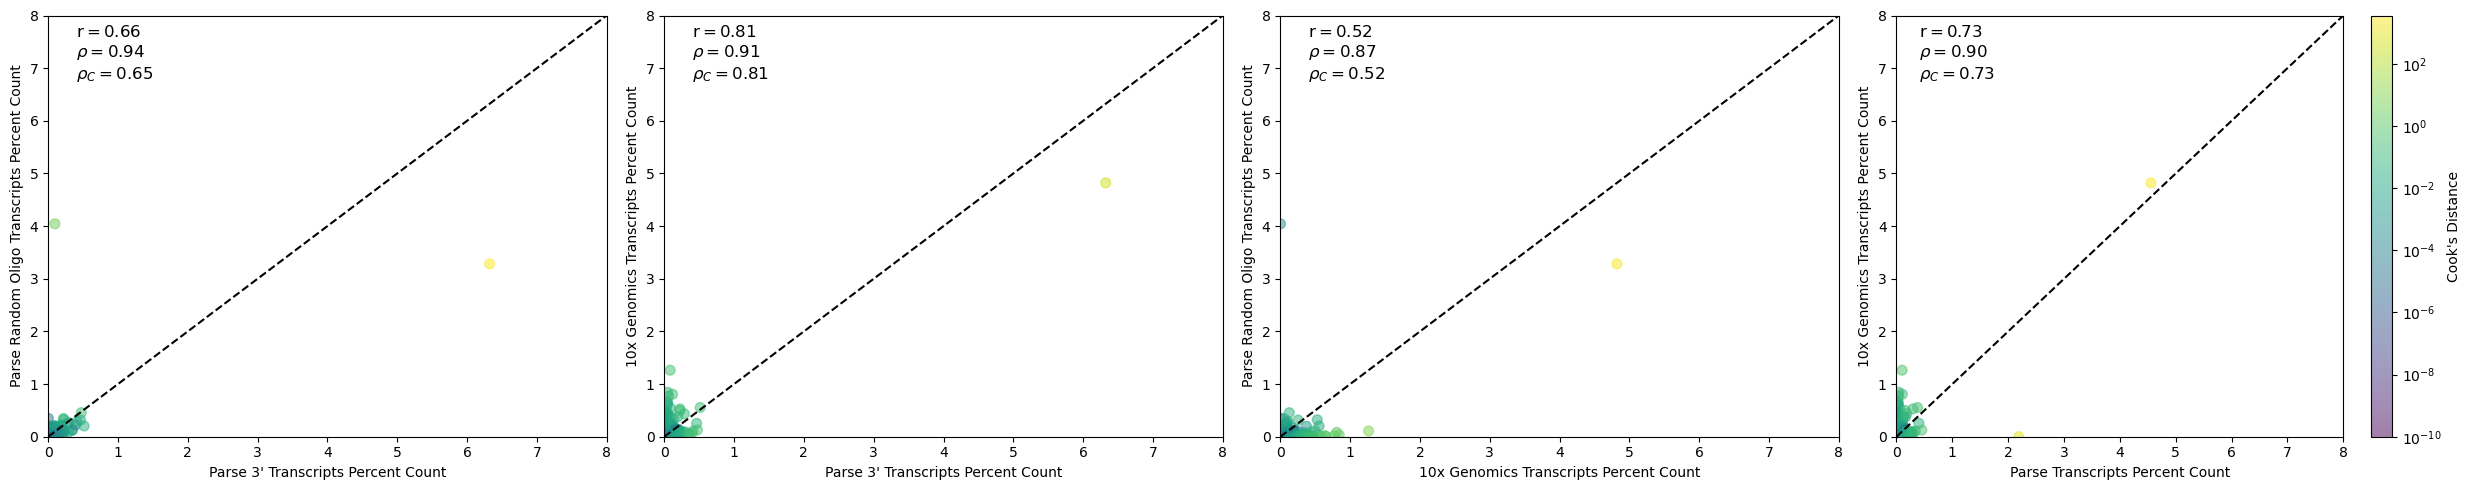

In [22]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

lim = 8

data_10x = datasets[0]
data_polyT = datasets[1]
data_randO = datasets[2]
data_parse = datasets[3]

TvO_genes = compare_genes(data_polyT, data_randO)
TvX_genes = compare_genes(data_polyT, data_10x)
XvO_genes = compare_genes(data_10x, data_randO)
PvX_genes = compare_genes(data_parse, data_10x)

c_values = TvO_genes['cooks_distance'].tolist() + TvX_genes['cooks_distance'].tolist() + XvO_genes['cooks_distance'].tolist()
norm = LogNorm(min(c_values), max(c_values))

scatter_genes(axs[0], TvO_genes, data_polyT, data_randO, xlim=lim, ylim=lim, norm=norm)
scatter_genes(axs[1], TvX_genes, data_polyT, data_10x, xlim=lim, ylim=lim,norm=norm)
scatter_genes(axs[2], XvO_genes, data_10x, data_randO, xlim=lim, ylim=lim,norm=norm)
plot = scatter_genes(axs[3], PvX_genes, data_parse, data_10x, xlim=lim, ylim=lim,norm=norm)

fig.colorbar(plot, label = "Cook's Distance")

plt.tight_layout()
plt.show()

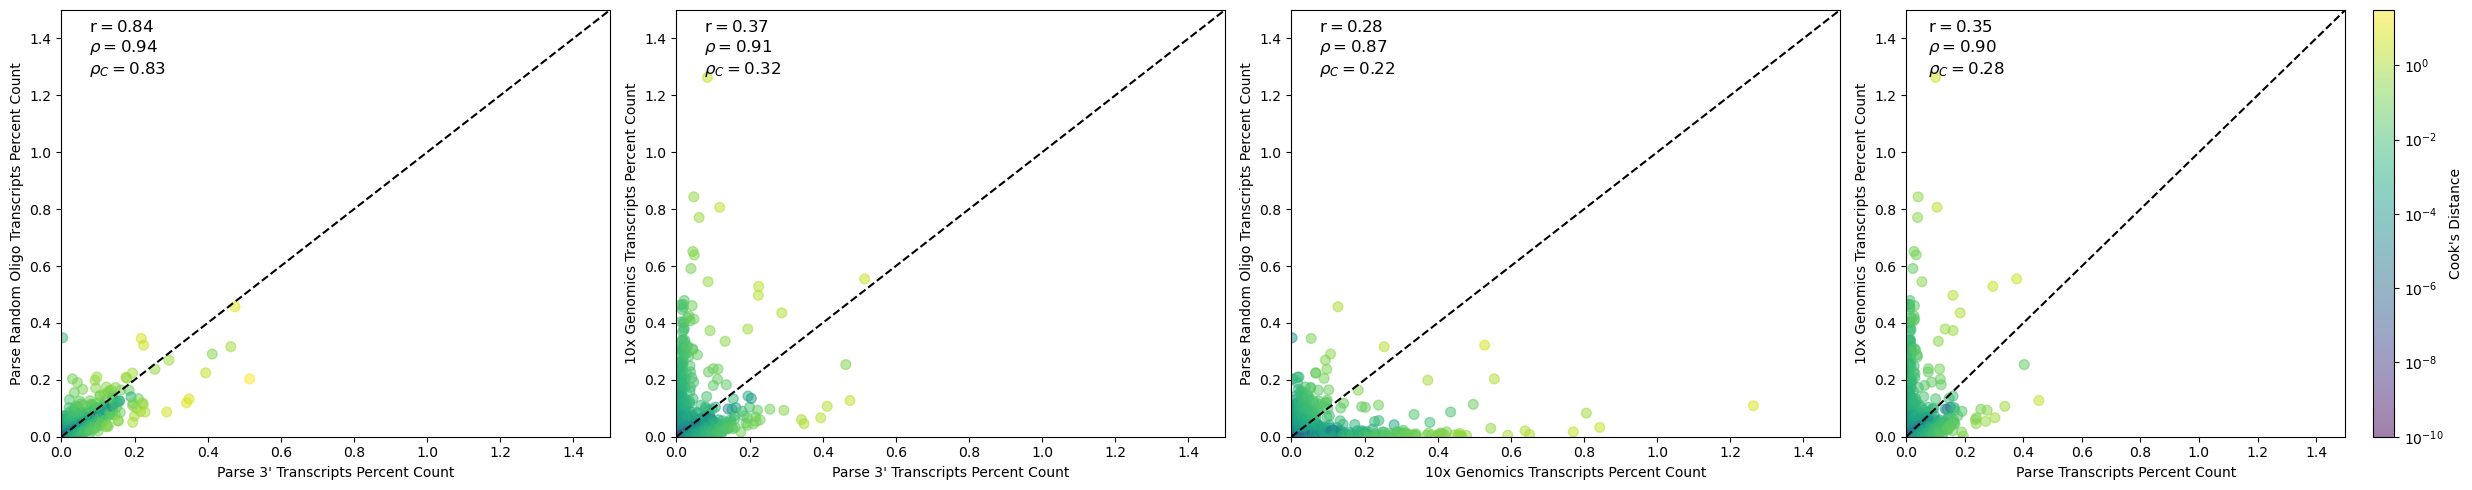

In [23]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

lim = 1.5

data_10x = datasets[0][:,datasets[0].var['percent_counts'] < lim]
data_polyT = datasets[1][:,datasets[1].var['percent_counts'] < lim]
data_randO = datasets[2][:,datasets[2].var['percent_counts'] < lim]
data_parse = datasets[3][:,datasets[3].var['percent_counts'] < lim]

TvO_genes = compare_genes(data_polyT, data_randO)
TvX_genes = compare_genes(data_polyT, data_10x)
XvO_genes = compare_genes(data_10x, data_randO)
PvX_genes = compare_genes(data_parse, data_10x)

c_values = TvO_genes['cooks_distance'].tolist() + TvX_genes['cooks_distance'].tolist() + XvO_genes['cooks_distance'].tolist()
norm = LogNorm(min(c_values), max(c_values))

scatter_genes(axs[0], TvO_genes, data_polyT, data_randO, xlim=lim, ylim=lim, norm=norm)
scatter_genes(axs[1], TvX_genes, data_polyT, data_10x, xlim=lim, ylim=lim,norm=norm)
scatter_genes(axs[2], XvO_genes, data_10x, data_randO, xlim=lim, ylim=lim,norm=norm)
plot = scatter_genes(axs[3], PvX_genes, data_parse, data_10x, xlim=lim, ylim=lim,norm=norm)

fig.colorbar(plot, label = "Cook's Distance")

plt.tight_layout()
plt.show()

In [24]:
for shared_data, string in zip([TvO_genes, TvX_genes, XvO_genes, PvX_genes], ("polyT vs randO", "polyT vs 10X", "10X vs randO", "Parse vs 10X")):
    shared_data.sort_values(by='cooks_distance', ascending=False, inplace=True)
    print("Top 10 outliers based on Cook's distance for", string, ":",  shared_data.index[:10].tolist())

Top 10 outliers based on Cook's distance for polyT vs randO : ['Ptma', 'Satb1', 'Rbm25', 'Atrx', 'Rag1', 'Hmgb1', 'mt-Co1', 'Prrc2c', 'Smc4', 'Hmgb2']
Top 10 outliers based on Cook's distance for polyT vs 10X : ['Ptma', 'mt-Co3', 'Satb1', 'mt-Atp6', 'mt-Co1', 'Prrc2c', 'Actb', 'Ptprc', 'Hmgb1', 'Atrx']
Top 10 outliers based on Cook's distance for 10X vs randO : ['mt-Co3', 'mt-Co1', 'mt-Co2', 'Tmsb4x', 'Xist', 'Rps8', 'Ptma', 'Rpl13', 'Tpt1', 'Satb1']
Top 10 outliers based on Cook's distance for Parse vs 10X : ['mt-Co3', 'Ptma', 'mt-Co1', 'Satb1', 'mt-Atp6', 'Actb', 'Hmgb1', 'Prrc2c', 'Ptprc', 'mt-Cytb']


In [25]:
for data in datasets:
    name = data.uns['title']
    genes = data.var
    top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index.tolist()
    print("Top 10 genes in", name, "data:")
    print(top_genes)
    print()

Top 10 genes in 10x Genomics data:
['Malat1', 'mt-Co3', 'mt-Atp6', 'Tmsb4x', 'mt-Co2', 'Rps8', 'Tpt1', 'Rpl13', 'Ptma', 'Trbc2']

Top 10 genes in Parse 3' data:
['Malat1', 'Satb1', 'Prrc2c', 'Ptprc', 'Ptma', 'Rbm25', 'Atrx', 'Xist', 'Hnrnpa2b1', 'Hmgb1']

Top 10 genes in Parse Random Oligo data:
['Malat1', 'Lars2', 'Satb1', 'Ptprc', 'Rag1', 'Ccnb1ip1', 'Prrc2c', 'Arpp21', 'Xist', 'mt-Co1']

Top 10 genes in Parse data:
['Malat1', 'Lars2', 'Satb1', 'Ptprc', 'Prrc2c', 'Xist', 'Ptma', 'Rag1', 'Arpp21', 'Rbm25']



In [26]:
with open("t2g.txt") as t2g:
    gene_ids = []
    for line in t2g:
        gene_ids.append(line.strip().split()[1])
gene_ids = list(set(gene_ids))
df_genes = pd.DataFrame({'gene_ids': gene_ids})

In [27]:
dict = {}

for data in datasets:
    dict[str(data.uns['name'])] = (df_genes['gene_ids'].isin(data.var['transcript_ids'])).tolist()
contents = pd.DataFrame(dict) 

upset = Upset.generate_plot(contents)
upset.show()
            

In [28]:
dict = {}

for data in datasets:
    top_data = data.var.sort_values(by='percent_counts',ascending=False).head(1000)
    dict[str(data.uns['name'])] = (df_genes['gene_ids'].isin(top_data['transcript_ids'])).tolist()
contents = pd.DataFrame(dict) 

upset = Upset.generate_plot(contents)
upset.show()

# Read/Gene Comparisons

In [40]:
def datasetT2G(data):
        data.var['gene_ids'] = data.var['transcript_ids'].str.split('.').str[0].tolist()
        genes = list(set(data.var['gene_ids'].tolist()))
        X = []
        gene_names = []
        
        for gene in genes:
            index = (data.var['gene_ids'] == gene).tolist()
            X.append(data.X[:,index].sum(axis=1))
            gene_names.append(data.var.index[index].tolist()[0].split('.')[0])

        X = np.hstack(X)

        # Stack into a new matrix
        if sparse.issparse(data.X):
            X = sparse.csr_matrix(X)

        var = data.var.groupby(['gene_ids']).sum().copy()
        var['gene_ids'] = var['transcript_ids'].str.split('.').str[0].tolist()
        var = var.set_index('gene_ids').loc[genes].reset_index(drop=True)
        var.drop(['transcript_ids'], axis=1, inplace=True)

        gene_data = anndata.AnnData(X=X, obs = data.obs.copy())
        gene_data.var = var
        gene_data.var.index = gene_names

        gene_data.uns['name'] = data.uns['name']
        gene_data.uns['title'] = data.uns['title']
        
        print(data.uns['name'] + " is finished")
        return gene_data
    
with multiprocessing.Pool(processes=4) as pool:
    gene_datasets = pool.map(datasetT2G, datasets)
    print("done")
     

/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning:

Transforming to str index.



polyT is finished


/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning:

Transforming to str index.



randO is finished


/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning:

Transforming to str index.



parse is finished


/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning:

Transforming to str index.



10x is finished
done


In [41]:
for data, gene_data in zip(datasets, gene_datasets):
    gene_data.write_h5ad("gene_" + data.uns['name'] + ".h5ad")

In [49]:
gene_datasets = []
for data in datasets:
    gene_datasets.append(anndata.read_h5ad("gene_" + data.uns['name'] + ".h5ad"))
for data in gene_datasets:
    data.var_names_make_unique()

/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.

/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.



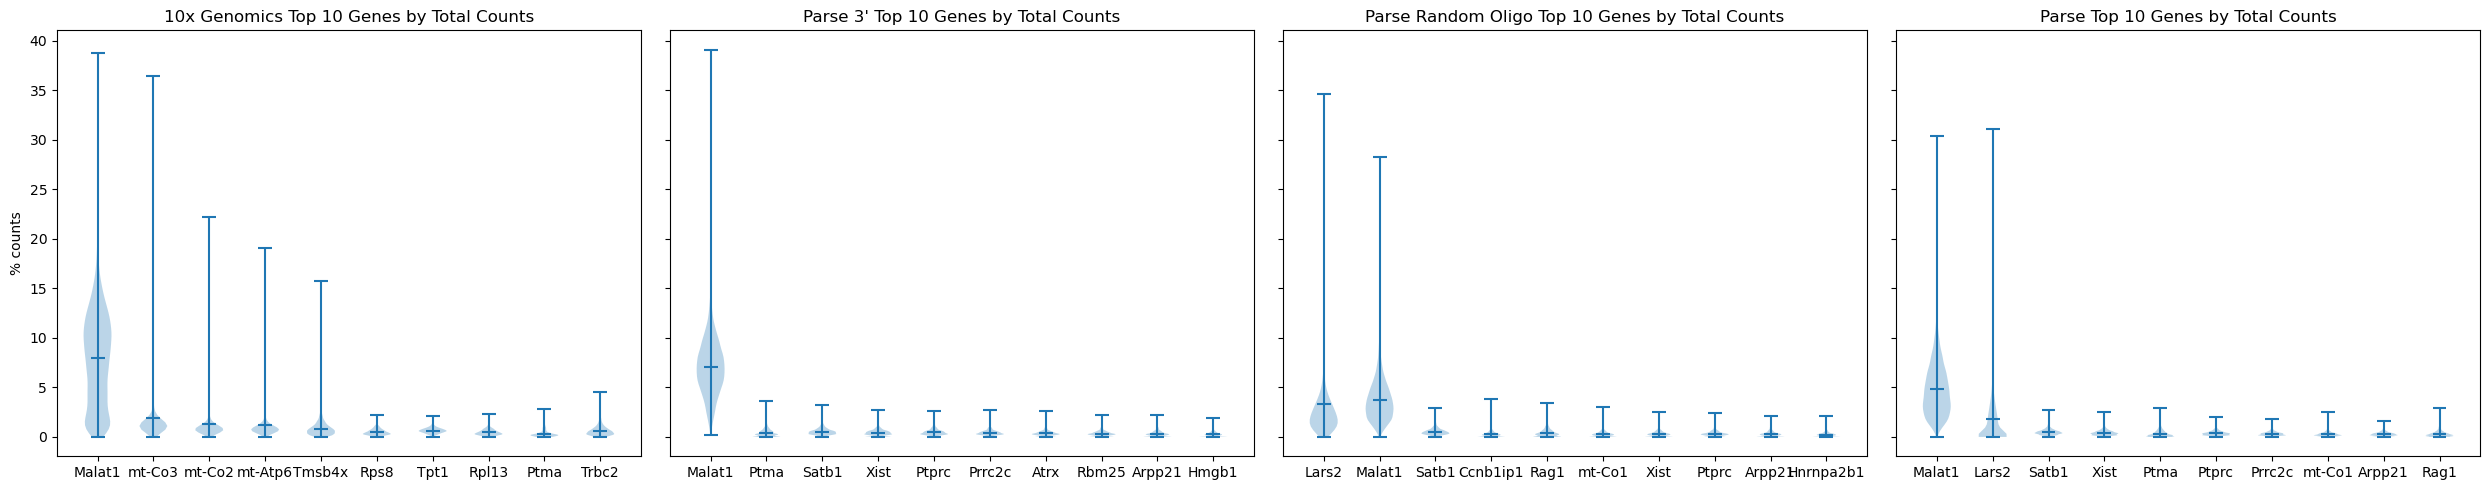

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)

for i, data in enumerate(gene_datasets):
    top_gene_counts(ax[i], data, transcript = False)

ax[0].set_ylabel("% counts")

plt.tight_layout()
plt.show()

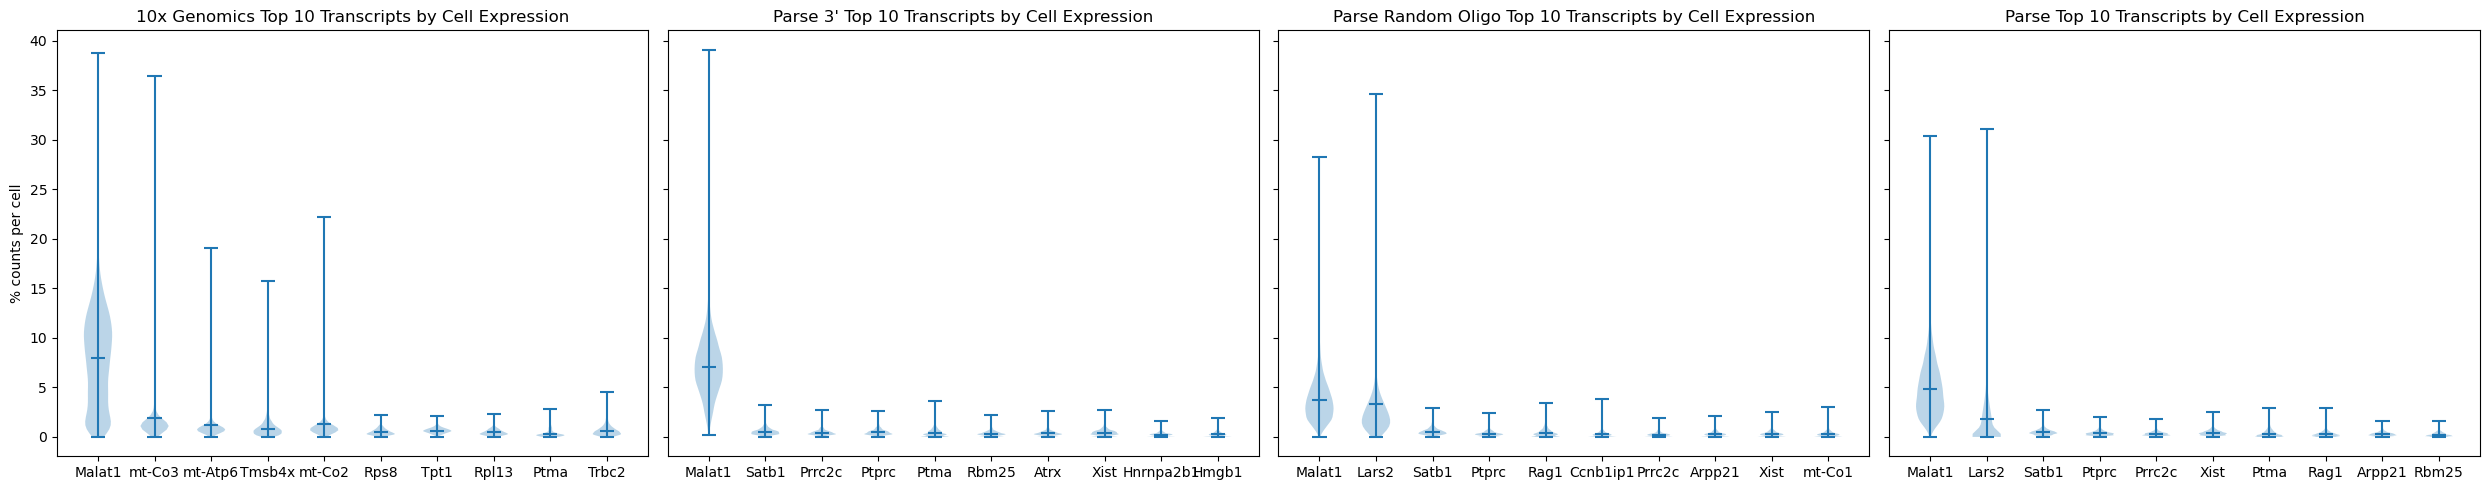

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)
for i, data in enumerate(gene_datasets):
    top_gene_cell_expression(ax[i], data)

ax[0].set_ylabel("% counts per cell")

plt.tight_layout()
plt.show()

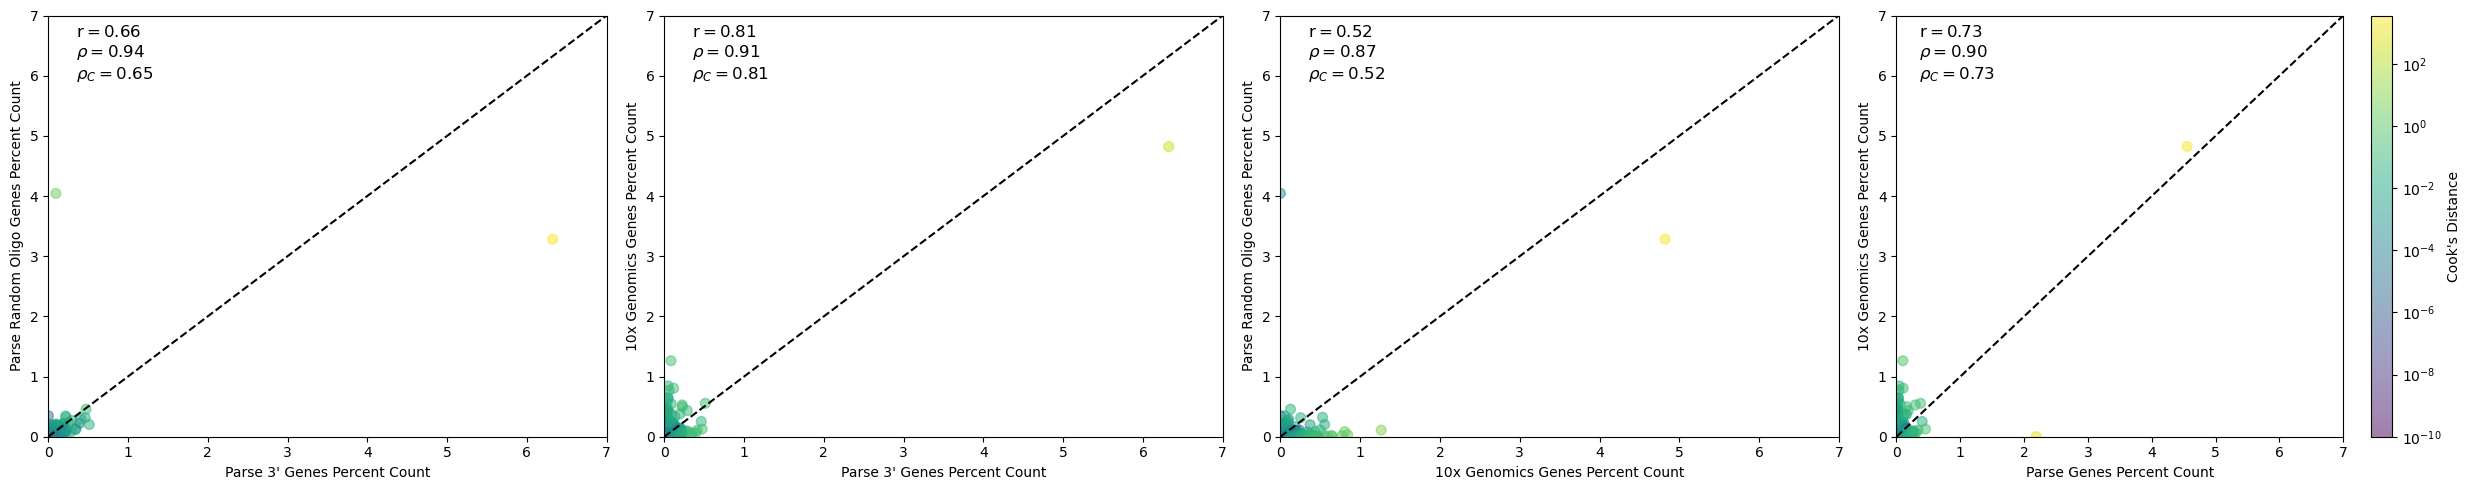

In [62]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

lim = 7

data_10x = gene_datasets[0]
data_polyT = gene_datasets[1]
data_randO = gene_datasets[2]
data_parse = gene_datasets[3]

TvO_genes = compare_genes(data_polyT, data_randO)
TvX_genes = compare_genes(data_polyT, data_10x)
XvO_genes = compare_genes(data_10x, data_randO)
PvX_genes = compare_genes(data_parse, data_10x)

c_values = TvO_genes['cooks_distance'].tolist() + TvX_genes['cooks_distance'].tolist() + XvO_genes['cooks_distance'].tolist()
norm = LogNorm(min(c_values), max(c_values))

scatter_genes(axs[0], TvO_genes, data_polyT, data_randO, xlim=lim, ylim=lim, norm=norm, transcript=False)
scatter_genes(axs[1], TvX_genes, data_polyT, data_10x, xlim=lim, ylim=lim,norm=norm, transcript=False)
scatter_genes(axs[2], XvO_genes, data_10x, data_randO, xlim=lim, ylim=lim,norm=norm, transcript=False)
plot = scatter_genes(axs[3], PvX_genes, data_parse, data_10x, xlim=lim, ylim=lim,norm=norm, transcript=False)

fig.colorbar(plot, label = "Cook's Distance")

plt.tight_layout()
plt.show()

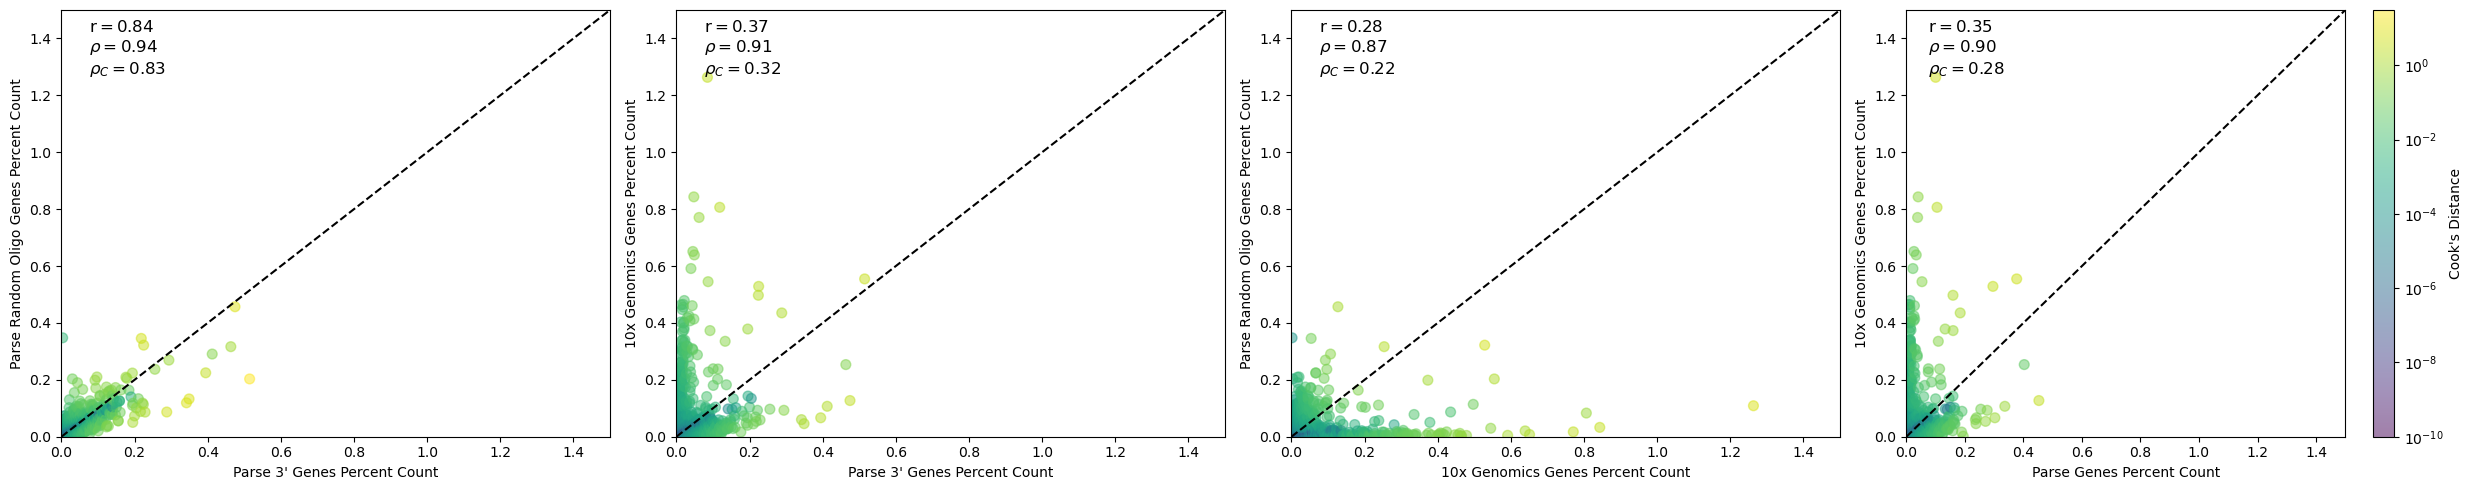

In [63]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))

lim = 1.5

data_10x = gene_datasets[0][:,gene_datasets[0].var['percent_counts'] < lim]
data_polyT = gene_datasets[1][:,gene_datasets[1].var['percent_counts'] < lim]
data_randO = gene_datasets[2][:,gene_datasets[2].var['percent_counts'] < lim]
data_parse = gene_datasets[3][:,gene_datasets[3].var['percent_counts'] < lim]

TvO_genes = compare_genes(data_polyT, data_randO)
TvX_genes = compare_genes(data_polyT, data_10x)
XvO_genes = compare_genes(data_10x, data_randO)
PvX_genes = compare_genes(data_parse, data_10x)

c_values = TvO_genes['cooks_distance'].tolist() + TvX_genes['cooks_distance'].tolist() + XvO_genes['cooks_distance'].tolist()
norm = LogNorm(min(c_values), max(c_values))

scatter_genes(axs[0], TvO_genes, data_polyT, data_randO, xlim=lim, ylim=lim, norm=norm, transcript=False)
scatter_genes(axs[1], TvX_genes, data_polyT, data_10x, xlim=lim, ylim=lim,norm=norm, transcript=False)
scatter_genes(axs[2], XvO_genes, data_10x, data_randO, xlim=lim, ylim=lim,norm=norm, transcript=False)
plot = scatter_genes(axs[3], PvX_genes, data_parse, data_10x, xlim=lim, ylim=lim,norm=norm, transcript=False)

fig.colorbar(plot, label = "Cook's Distance")

plt.tight_layout()
plt.show()

In [56]:
for shared_data, string in zip([TvO_genes, TvX_genes, XvO_genes, PvX_genes], ("polyT vs randO", "polyT vs 10X", "10X vs randO", "Parse vs 10X")):
    shared_data.sort_values(by='cooks_distance', ascending=False, inplace=True)
    print("Top 10 outliers based on Cook's distance for", string, ":",  shared_data.index[:10].tolist())

Top 10 outliers based on Cook's distance for polyT vs randO : ['Malat1', 'Lars2', 'Satb1', 'Rag1', 'mt-Co1', 'Ptma', 'Arpp21', 'Xist', 'Ptprc', 'Hnrnpa2b1']
Top 10 outliers based on Cook's distance for polyT vs 10X : ['Malat1', 'Satb1', 'mt-Co3', 'Prrc2c', 'Ptma', 'mt-Atp6', 'Ptprc', 'mt-Co1', 'Atrx', 'Actb']
Top 10 outliers based on Cook's distance for 10X vs randO : ['Malat1', 'mt-Co3', 'mt-Co2', 'Tmsb4x', 'mt-Atp6', 'Rps8', 'Tpt1', 'Rpl13', 'Trbc2', 'Rpl41']
Top 10 outliers based on Cook's distance for Parse vs 10X : ['Malat1', 'Lars2', 'mt-Co3', 'Satb1', 'Ptma', 'mt-Co1', 'mt-Atp6', 'Ptprc', 'Actb', 'Prrc2c']


In [64]:
for data in datasets:
    name = data.uns['title']
    genes = data.var
    top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index.tolist()
    print("Top 10 genes in", name, "data:")
    print(top_genes)
    print()

Top 10 genes in 10x Genomics data:
['Malat1', 'mt-Co3', 'mt-Atp6', 'Tmsb4x', 'mt-Co2', 'Rps8', 'Tpt1', 'Rpl13', 'Ptma', 'Trbc2']

Top 10 genes in Parse 3' data:
['Malat1', 'Satb1', 'Prrc2c', 'Ptprc', 'Ptma', 'Rbm25', 'Atrx', 'Xist', 'Hnrnpa2b1', 'Hmgb1']

Top 10 genes in Parse Random Oligo data:
['Malat1', 'Lars2', 'Satb1', 'Ptprc', 'Rag1', 'Ccnb1ip1', 'Prrc2c', 'Arpp21', 'Xist', 'mt-Co1']

Top 10 genes in Parse data:
['Malat1', 'Lars2', 'Satb1', 'Ptprc', 'Prrc2c', 'Xist', 'Ptma', 'Rag1', 'Arpp21', 'Rbm25']



In [65]:
dict = {}

for data in datasets:
    dict[str(data.uns['name'])] = (df_genes['gene_ids'].isin(data.var['transcript_ids'])).tolist()
contents = pd.DataFrame(dict) 

upset = Upset.generate_plot(contents)
upset.show()

In [66]:
dict = {}

for data in datasets:
    top_data = data.var.sort_values(by='percent_counts',ascending=False).head(1000)
    dict[str(data.uns['name'])] = (df_genes['gene_ids'].isin(top_data['transcript_ids'])).tolist()
contents = pd.DataFrame(dict) 

upset = Upset.generate_plot(contents)
upset.show()

# Transcript DataFrames